# Álvaro Huertas García

In this notebook we explore in which level words are common or unique among different biomedic text class. Moreover, we analyze how the polarity and subjectivity sentimens are displayed by class. 

In [1]:
!pip install Unidecode

     |████████████████████████████████| 245kB 4.1MB/s eta 0:00:01


In [9]:
import unidecode
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import sys
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from textblob import TextBlob

import spacy
print('spaCy Version: %s' % (spacy.__version__))
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/huertas97/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/huertas97/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/huertas97/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ModuleNotFoundError: No module named 'textblob'

In [0]:
np.random.seed(1)

In [2]:
COLAB = True

if COLAB:
    import urllib
    # Data
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1zJuh8XJTf_5hPZ8jVEUtGW1BnBZ6Yy4z",
                              "precision_medicine.zip")
    # Long stop word
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1PcVSBLgIpJVXAj4JD8_EQAGprte4zuyn",
                              "long_stop_words.txt")
    # Clinical stop words
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1M5a92cvQ3L7okuYHBuZh2K1f_MsrupuF",
                              "clinical_stop_words.txt")

In [3]:
f = open("long_stop_words.txt", "+r")
long_stopwords = f.read().split("\n")
len(long_stopwords)

853

In [4]:
f = open("clinical_stop_words.txt", "+r")
clinical_stopwords = f.read().split("\n")
len(clinical_stopwords)

811

In [5]:
!unzip precision_medicine.zip 

Archive:  precision_medicine.zip
   creating: precision_medicine/
  inflating: precision_medicine/Alzheimer_abstracts.tsv  
   creating: __MACOSX/
   creating: __MACOSX/precision_medicine/
  inflating: __MACOSX/precision_medicine/._Alzheimer_abstracts.tsv  
  inflating: precision_medicine/Bladder_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Bladder_Cancer_abstracts.tsv  
  inflating: precision_medicine/Breast_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Breast_Cancer_abstracts.tsv  
  inflating: precision_medicine/Cervical_Cancer_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._Cervical_Cancer_abstracts.tsv  
  inflating: precision_medicine/negative_abstracts.tsv  
  inflating: __MACOSX/precision_medicine/._negative_abstracts.tsv  
  inflating: __MACOSX/._precision_medicine  


In [6]:
files = [('Alzheimer_abstracts.tsv', 'Alzheimer'),
         ('Bladder_Cancer_abstracts.tsv', 'Bladder Cancer'),
         ('Breast_Cancer_abstracts.tsv', 'Breast Cancer'),
         ('Cervical_Cancer_abstracts.tsv', 'Cervical Cancer'),
         ('negative_abstracts.tsv', 'Negative'),]

input_folder = './precision_medicine/'

In [7]:
def load_file(file_name):
    with open(file_name) as f:
        examples = []
        content = f.readlines()
        for l in content:
            aux = l.split('\t')
            examples.append((aux[0], (' '.join(aux[1:])).replace('\n', ' ')))
        return examples

In [10]:
# Variables donde almacenamos cada texto y su etiqueta
narratives = []
labels = []

# Para cada uno de los 5 archivos extraemos sus textos y le asignamos la etiqueta
for f,label in files:
    aux = load_file(input_folder + f)
    narratives.extend([x[1] for x in aux])
    labels.extend(len(aux)*[label])

labels = np.array(labels)

len(narratives), len(labels)

(5000, 5000)

Transform the data into pandas data frame

In [0]:
import pandas as pd
df_biomedic = pd.DataFrame()
df_biomedic["narratives"] = narratives
df_biomedic["labels"] = labels
df_biomedic

,narratives,labels
0,How the cognitive reserve interacts with beta-...,Alzheimer
1,Negative Bias in the Perception and Memory of ...,Alzheimer
2,Anosognosia and Its Relation to Psychiatric Sy...,Alzheimer
3,Family history and APOE4 risk for Alzheimer's ...,Alzheimer
4,Data-driven regions of interest for longitudin...,Alzheimer
...,...,...
4995,Universal Coverage without Universal Access: I...,Negative
4996,Decreased use of glucocorticoids in biological...,Negative
4997,Evaluating the Utility of Single-Locus DNA Bar...,Negative
4998,Convection-driven kinematic dynamos at low Ros...,Negative


In [0]:
print(len(narratives))
dic = {}
unique_labels, counts = np.unique(labels, return_counts=True)
for aa,bb in zip(unique_labels,counts):
    print(aa+':', bb)
    dic[aa] = bb

5000
Alzheimer: 1000
Bladder Cancer: 1000
Breast Cancer: 1000
Cervical Cancer: 1000
Negative: 1000


In [0]:
print(len(df_biomedic['narratives'].iloc[0]))
print(len(narratives[0]))

1842
1842


## Pre-processing



In [0]:
def preprocessor(text, stoptext = "long", lemmatizer = "nltk"):
  sys.stdout.write('.')
  sys.stdout.flush()


  # Text to unicode
  text = unidecode.unidecode(text)

  # Remove introduction words for sections
  text = re.sub("[A-Z]{0,}\s[A-Z]+:", "", text) 

  # Lowercase and remove extra spaces
  text = text.strip().lower()



  # E mail
  text = re.sub(r"e\s?-\s?mail", "email", text)

  # Substitute p value
  text = re.sub('p\s?[<=]\s?0?[.,]0[0-5]+', 'hppv', text) # Significant
  text = re.sub('p\s?[>=]\s?[\d]+[.,]?\d*', 'lppv', text) # Non-significant

  # Separate punctation to replace numbers for NUM better
  from string import punctuation
  punctuation_marks = set(punctuation)
  punctuation_marks.update(chr(177))

  for i in punctuation_marks:
    element = "\\"+i # scape the character
    sub_element = " "+i+" " # Example "=" --> " = "
    text = re.sub(element, sub_element, text)


  # Substitute irrelevant (isolated) numbers by NUM
  text = re.sub( '[^A-Za-z][\-~]?[0-9][0-9]*\s?[.,]?\s?[0-9]+[^A-Za-z]', " num ", text)
  text = re.sub( "\s[0-9]+\s", " num ", text)

  # Tokenize the text
  tokenized_text = nltk.word_tokenize(text)

  

  # Delete Punctuation
  tokenized_text = [i for i in tokenized_text if i not in punctuation_marks]


    # Delete stop words
  if stoptext == "spacy":
    spacy_nlp = spacy.load('en_core_web_sm')
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    stop_words = sorted(spacy_stopwords)

  if stoptext == "nltk":
    nltk_stopwords = nltk.corpus.stopwords.words('english')
    stop_words = sorted(nltk_stopwords)

  if stoptext == "clinical":
    stop_words = clinical_stopwords

  if stoptext == "long":
    stop_words = sorted(long_stopwords)

  tokenized_text = [i for i in tokenized_text if i not in stop_words]


  # Lemmanization
  if lemmatizer == "nltk":
    lemmatizer = WordNetLemmatizer().lemmatize
    lemmatized_text = [lemmatizer(word) for word in tokenized_text]

  
  if lemmatizer == "spacy":
    nlp = spacy.load('en', disable=['parser', 'ner'])
    doc = nlp(" ".join(tokenized_text))
    lemmatized_text = [token.lemma_ for token in doc]


  # Join all the text  
  full_text = " ".join(lemmatized_text)

  return full_text

You can clean the text individually, but this will be done in the Pipeline

In [0]:
# df_biomedic['clean'] = df_biomedic['narratives'].apply(preprocessor, args = ("nltk", "nltk"))


Next we are going to create some news variables columns to try to improve the quaity of our classifier, we will create with TextBlob:

   1. Polarity: to check the sentiment of the text
   2. Subjectivity: to check if text is objective or subjective
   



In [0]:
def polarity_txt(text):
  sys.stdout.write('.')
  sys.stdout.flush()
  return TextBlob(text).sentiment[0]



def subj_txt(text):
  sys.stdout.write('.')
  sys.stdout.flush()
  return  TextBlob(text).sentiment[1]


df_biomedic['polarity'] = df_biomedic['narratives'].apply(polarity_txt)
df_biomedic['subjectivity'] = df_biomedic['narratives'].apply(subj_txt)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Check the results

In [0]:
df_biomedic.head(11)

,narratives,labels,polarity,subjectivity
0,How the cognitive reserve interacts with beta-...,Alzheimer,0.076002,0.439965
1,Negative Bias in the Perception and Memory of ...,Alzheimer,0.068687,0.618182
2,Anosognosia and Its Relation to Psychiatric Sy...,Alzheimer,0.113021,0.518750
3,Family history and APOE4 risk for Alzheimer's ...,Alzheimer,0.033088,0.383824
4,Data-driven regions of interest for longitudin...,Alzheimer,0.142308,0.421154
5,"Awareness, apathy, and depression in Alzheimer...",Alzheimer,0.277273,0.470455
6,Dual role of cellular prion protein in normal ...,Alzheimer,0.070455,0.528030
7,Lewy Body Disorders. Dementia syndromes associ...,Alzheimer,0.000000,0.400000
8,Late-Onset Alzheimer Disease. The oldest-old r...,Alzheimer,0.072917,0.549405
9,Early-Onset Alzheimer Disease. Early-onset Alz...,Alzheimer,0.055952,0.438312


In [0]:
%%time
vectorizer = TfidfVectorizer( min_df =0, max_df=0.7, max_features=8500, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=preprocessor)

vectorizer.fit(df_biomedic.narratives)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [0]:
matrix = vectorizer.transform(df_biomedic[df_biomedic.labels == "Alzheimer"].narratives).todense()
category_words = matrix.sum(axis=0)
category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
print(category_words_freq)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [0]:
def create_tf_matrix(category):
    return vectorizer.transform(df_biomedic[df_biomedic.labels == category].narratives)

def create_term_freq(matrix, cat):
  category_words = matrix.sum(axis=0)
  category_words_freq = [(word, category_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  return pd.DataFrame(list(sorted(category_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms', cat])

for cat in df_biomedic.labels.unique():
  print("Top 10 terms for: ", cat)
  df_right = create_term_freq(create_tf_matrix(cat), cat).head(15)
  print(df_right)
  print("###############")
  if cat != 'Alzheimer':
    df_top5_words = df_top5_words.merge(df_right, how='outer')
  else:
    df_top5_words = df_right.copy()
  print(df_top5_words.shape )

Top 10 terms for:  Alzheimer
...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [0]:
!pip install textacy

In [0]:
from textacy.viz.termite import draw_termite_plot

In [0]:
df_top5_words.head(50)

,Terms,Alzheimer,Bladder Cancer,Breast Cancer,Cervical Cancer,Negative
0,alzheimer,61.762105,NaN,NaN,NaN,NaN
1,disease,59.801705,NaN,NaN,NaN,12.271220
2,ad,59.486707,NaN,NaN,NaN,NaN
3,alzheimer disease,57.398647,NaN,NaN,NaN,NaN
4,dementia,35.732137,NaN,NaN,NaN,NaN
5,brain,31.206574,NaN,NaN,NaN,NaN
6,cognitive,30.203686,NaN,NaN,NaN,NaN
7,amyloid,28.140992,NaN,NaN,NaN,NaN
8,disease ad,25.831208,NaN,NaN,NaN,NaN
9,abeta,23.751086,NaN,NaN,NaN,NaN


In [0]:
df_top5_words.fillna(0, inplace=True )
df_top5_words.set_index('Terms', inplace=True)
df = df_top5_words.copy()
df_norm = (df) / (df.max() - df.min())

In [0]:
df_norm.head()

,Alzheimer,Bladder Cancer,Breast Cancer,Cervical Cancer,Negative
Terms,,,,,
alzheimer,1.000000,0.0,0.0,0.0,0.000000
disease,0.968259,0.0,0.0,0.0,0.463245
ad,0.963159,0.0,0.0,0.0,0.000000
alzheimer disease,0.929351,0.0,0.0,0.0,0.000000
dementia,0.578545,0.0,0.0,0.0,0.000000


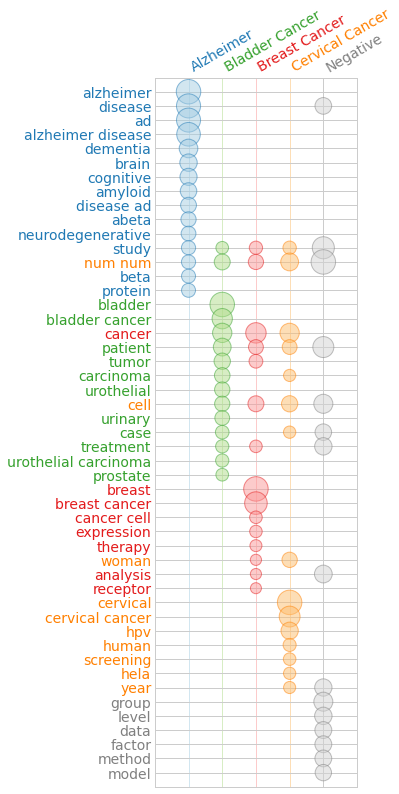

In [0]:
draw_termite_plot(np.array(df_norm.values),df_top5_words.columns,df_top5_words.index, highlight_cols=[0, 1, 2, 3])

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

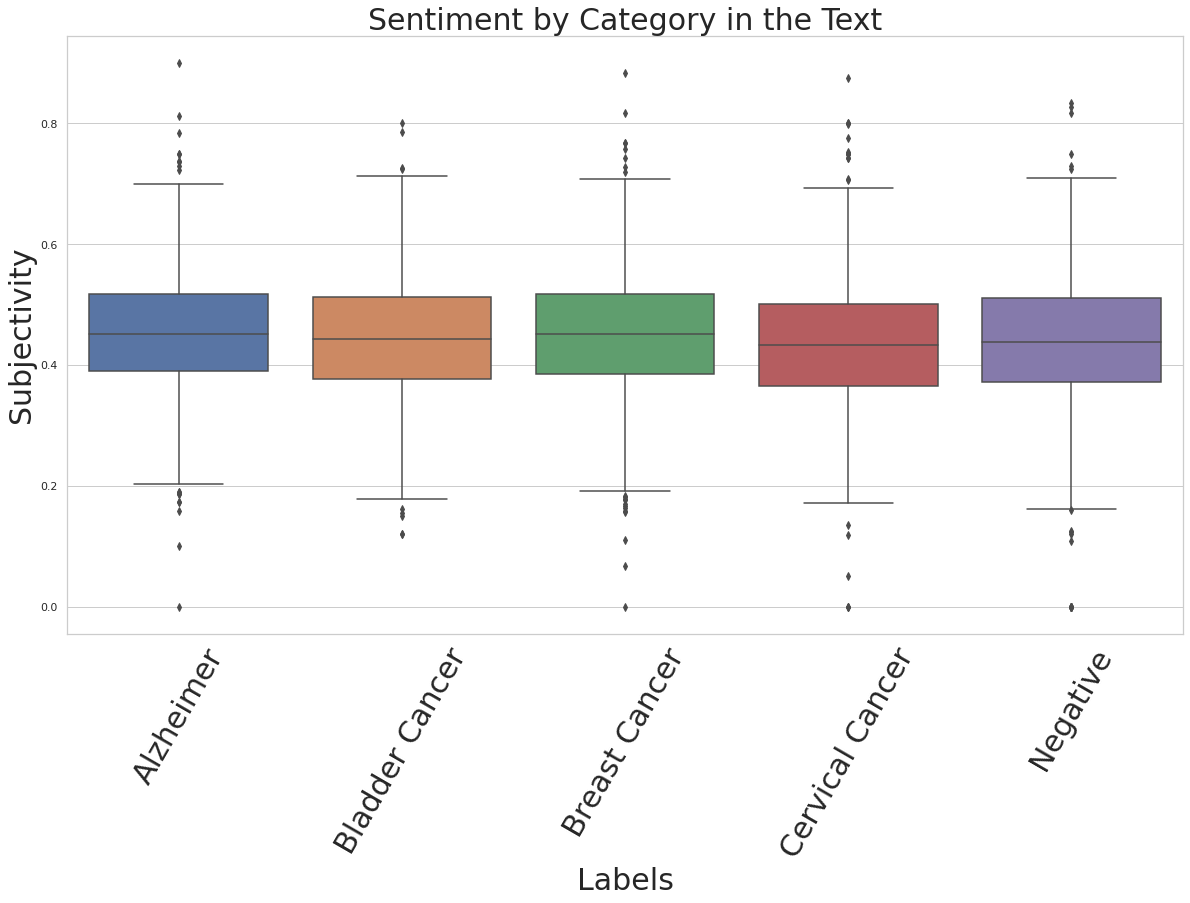

In [0]:
plt.figure(figsize=(20,11))
ax = sns.boxplot(x="labels", y="subjectivity", data=df_biomedic)
# ax = sns.swarmplot(x="category", y="polarity", data=df_news, color=".25")
ax.set_title('Sentiment by Category in the Text', fontsize = 30)
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize = 30)
l = ax.set_ylabel(ylabel = "Subjectivity", fontsize = 30)
l = ax.set_xlabel(xlabel = "Labels", fontsize = 30)